# Vehicle Image Classification

### The aim of this project is to classify a vehicle image which type of vehicle it is.

### First we will try to visualize the training images to understand how to perform this multiclass image classification. Then we will use Neural Network approaches: MLP and CNN, to train the model and finally compare the validation accuracy of both the models.

#### The vehicle images dataset consists of 15,645 color images in 7 classes.

- Here are the classes in the dataset, as follows:
- "City Car" includes micro car, hatchback, and city car.
- "Sedan" includes sedans and coupes.
- "Multi Purpose Vehicle" includes only Multi Purpose Vehicle.
- "Sport Utility Vehicle" includes only Sport Utility Vehicles.
- "Van" includes vans and campervans.
- "Truck" includes only medium sized trucks.
- "Big Truck" includes only large sized trucks.

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import skimage
from skimage.transform import resize

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils import np_utils

import tensorflow as tf
import cv2
from glob import glob
from matplotlib import pyplot as plt
import random
import math
import os
import numpy as np
from numpy.random import seed
seed(100)
tf.random.set_seed(101) 

### Loading the paths of the training images set

In [2]:
paths=r'D:/ML/Vehicle Image Classification/Dataset/train/'

### Multiclass classification classes

In [3]:
categories = os.listdir(paths)
print("No. of categories of images in the train set = ",len(categories))

No. of categories of images in the train set =  7


In [4]:
categories

['Big Truck',
 'City Car',
 'Multi Purpose Vehicle',
 'Sedan',
 'Sport Utility Vehicle',
 'Truck',
 'Van']

### Since this is a supervised learning approach to train the model we will have to label the images before giving it as input to the CNN model


In [5]:
def load_img_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        n = 0
        for image_name in os.listdir(paths+"/"+category):
            if n==300:
                break
                
            #load image data into an array
            img = cv2.imread(paths+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            
             #resizing the image
            resized_img = img_array.resize((256, 256))
            
            #converting the image array to numpy array before appending it to the list
            img_lst.append(np.array(resized_img))
            
            if(index==0):
                v_type = "Big Truck"
            elif(index==1):
                v_type = "City Car"
            elif(index==2):
                v_type = "Multi Purpose Vehicle"
            elif(index==3):
                v_type = "Sedan"
            elif(index==4):
                v_type = "Sport Utility Vehicle"
            elif(index==5):
                v_type = "Truck"
            else:
                v_type = "Van"
                
            #appending label
            labels.append(v_type)
            
            n+=1
    return img_lst, labels

#### Converting the images and labels into numpy arrays

In [6]:
images, labels = load_img_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2100 
No. of labels loaded =  2100
<class 'list'> <class 'list'>


In [7]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2100, 256, 256, 3) 
Labels shape =  (2100,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Visualizing the vehicle images with their true labels

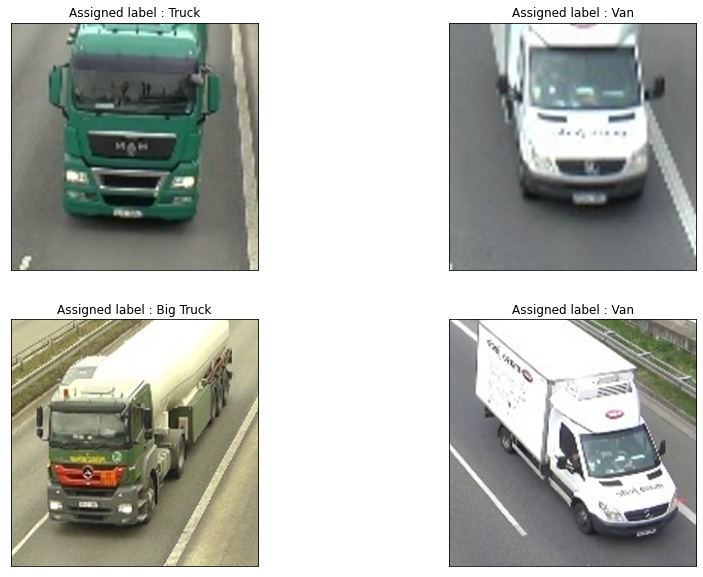

In [8]:
def display_label_images(images, labels):
    plt.figure(1 , figsize = (15 , 10))
    n = 0 
    for i in range(4):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(2, 2, n)
        plt.subplots_adjust(hspace = 0.2 , wspace = 0.1)
        plt.imshow(images[r[0]])
        
        
        plt.title('Assigned label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_label_images(images, labels)

### Performing Data Augmentation using ImageDataGenerator to import training images and augment more images

In [9]:
classes = ['Big Truck','City Car','Multi Purpose Vehicle','Sedan','Sport Utility Vehicle','Truck','Van']

In [10]:
dataPath =  r'D:/ML/Vehicle Image Classification/Dataset/train/'
resizeTuple = (64, 64)
resizeDim = (64, 64, 3)
numLabels = 29
batchSize = 64

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=0.1)

train_generator = data_generator.flow_from_directory(dataPath, target_size=resizeTuple, batch_size=batchSize, shuffle=True, subset="training")
val_generator = data_generator.flow_from_directory(dataPath, target_size=resizeTuple, batch_size=batchSize, subset="validation")

Found 14085 images belonging to 7 classes.
Found 1560 images belonging to 7 classes.


### Defining a function to display sample images from the dataset when their corresponding labels are given as input 

In [11]:
def plotSample(vehicle):
    print("Samples images " + vehicle)
    basePath = r'D:/ML/Vehicle Image Classification/Dataset/train/'
    imagePath = basePath + vehicle + '/**'
    pathData = glob(imagePath)
    
    plt.figure(figsize=(16,16))
    images = random.sample(pathData, 3)
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(images[0]))
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(images[1]))
    plt.subplot(1,3,3)
    plt.imshow(cv2.imread(images[2]))
    plt.colorbar()
    plt.show()
    return

Samples images Big Truck


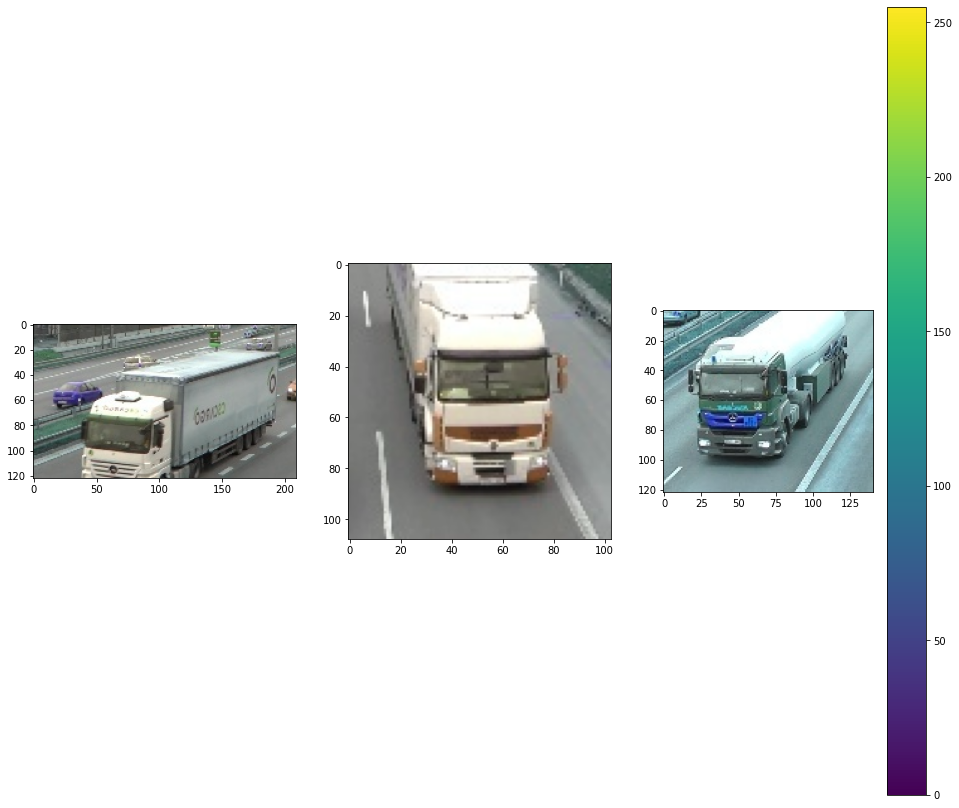

Samples images City Car


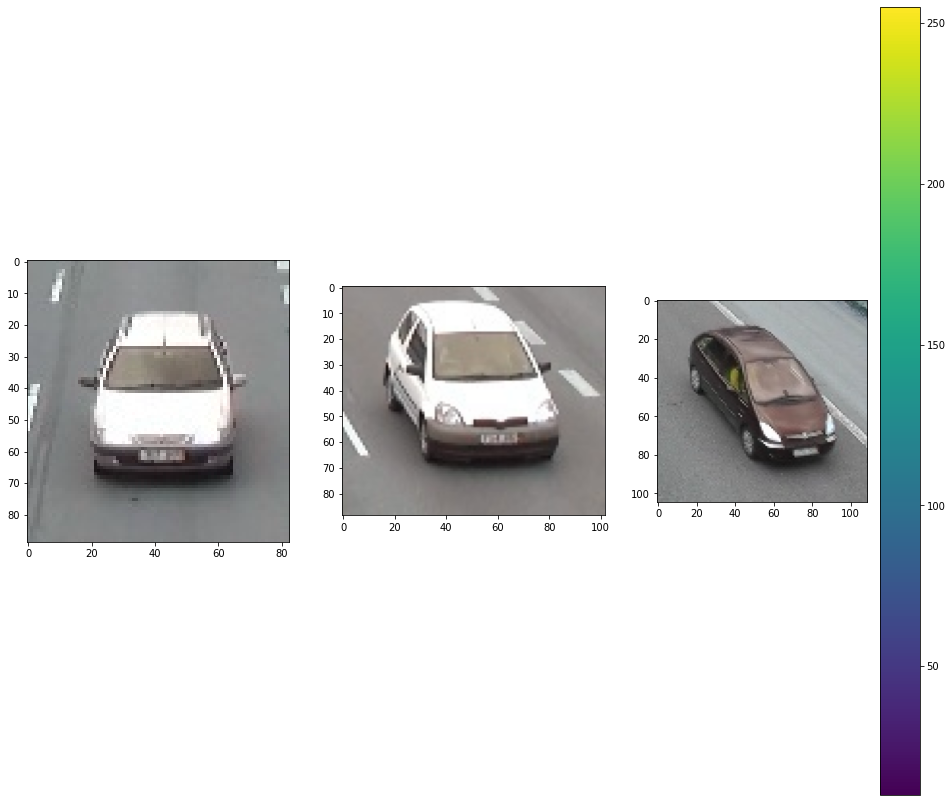

Samples images Multi Purpose Vehicle


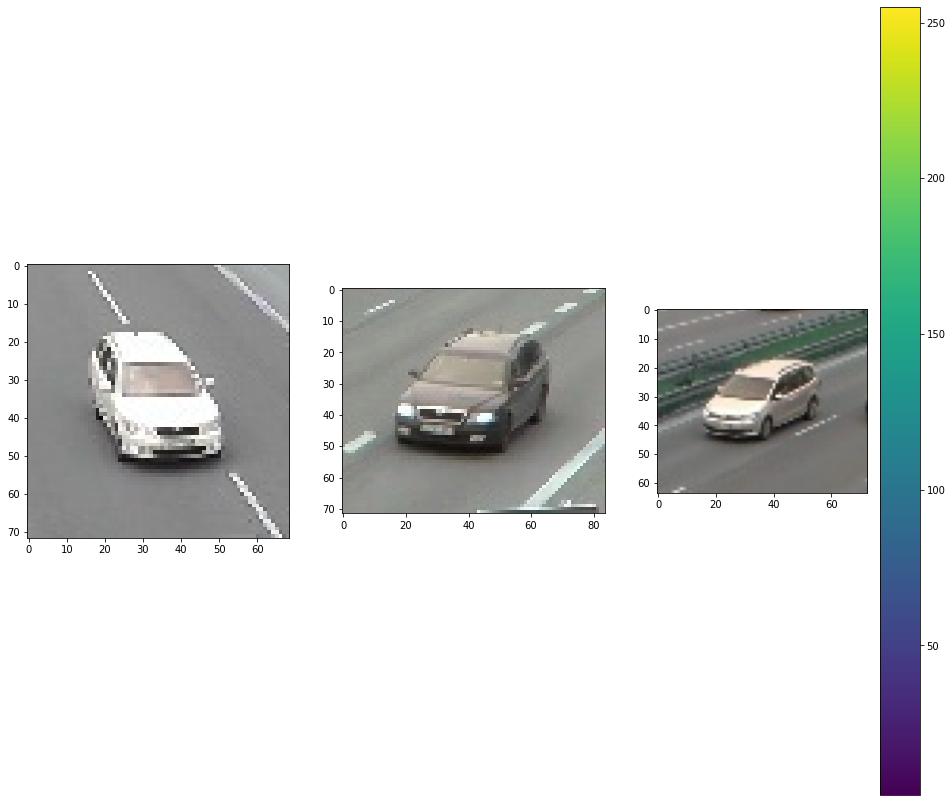

Samples images Sedan


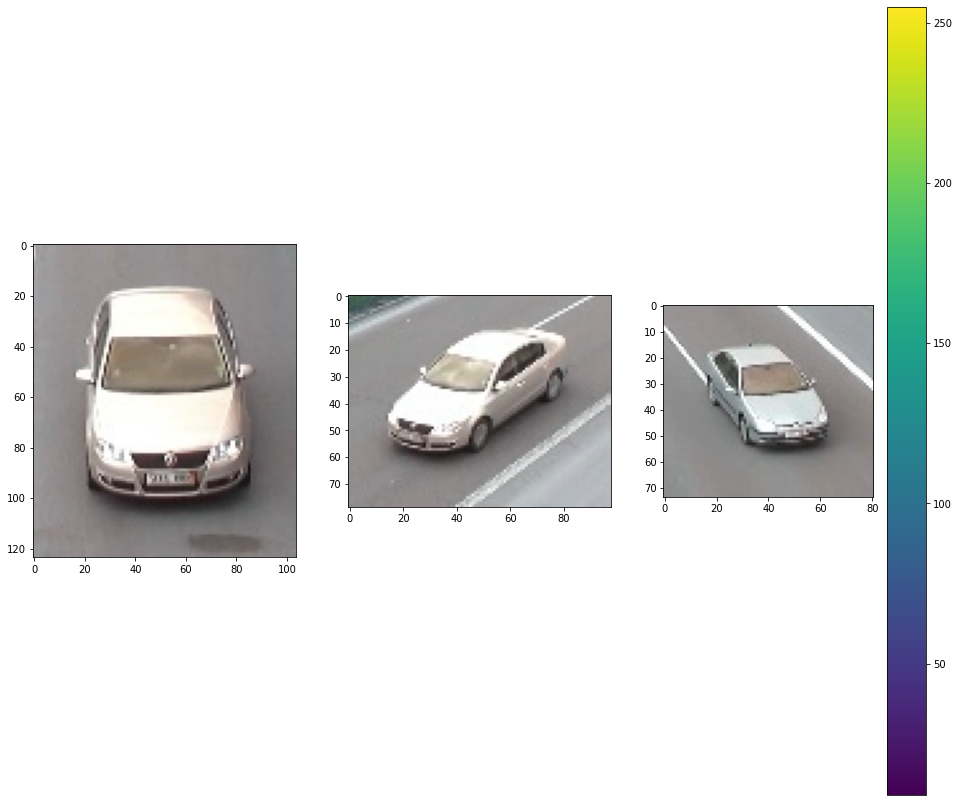

Samples images Sport Utility Vehicle


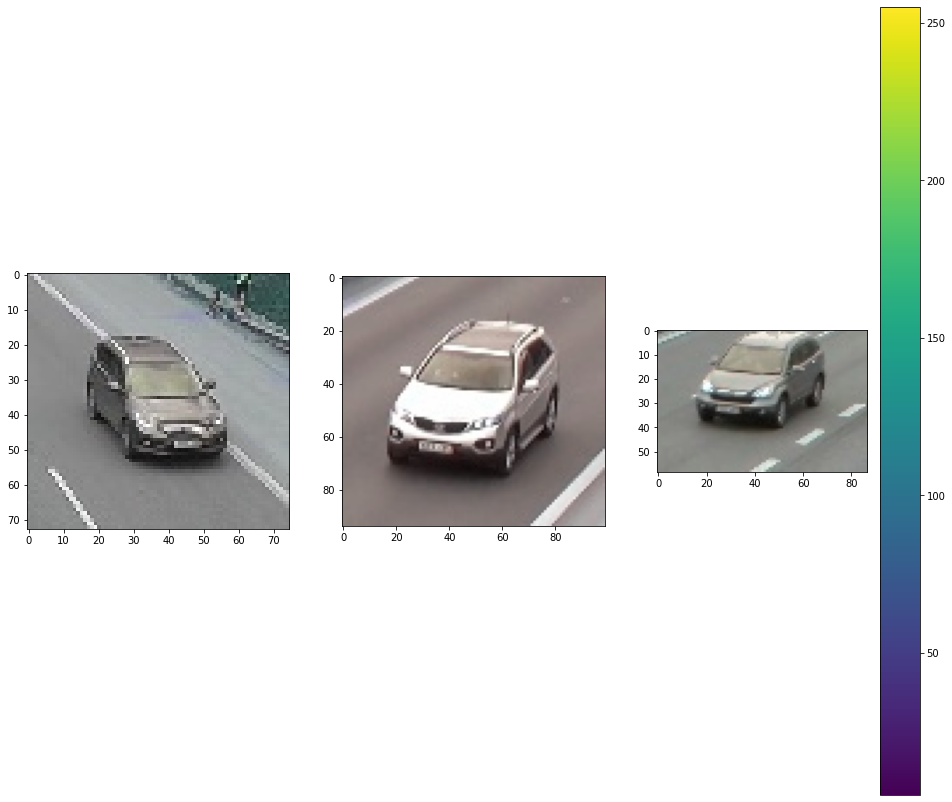

Samples images Truck


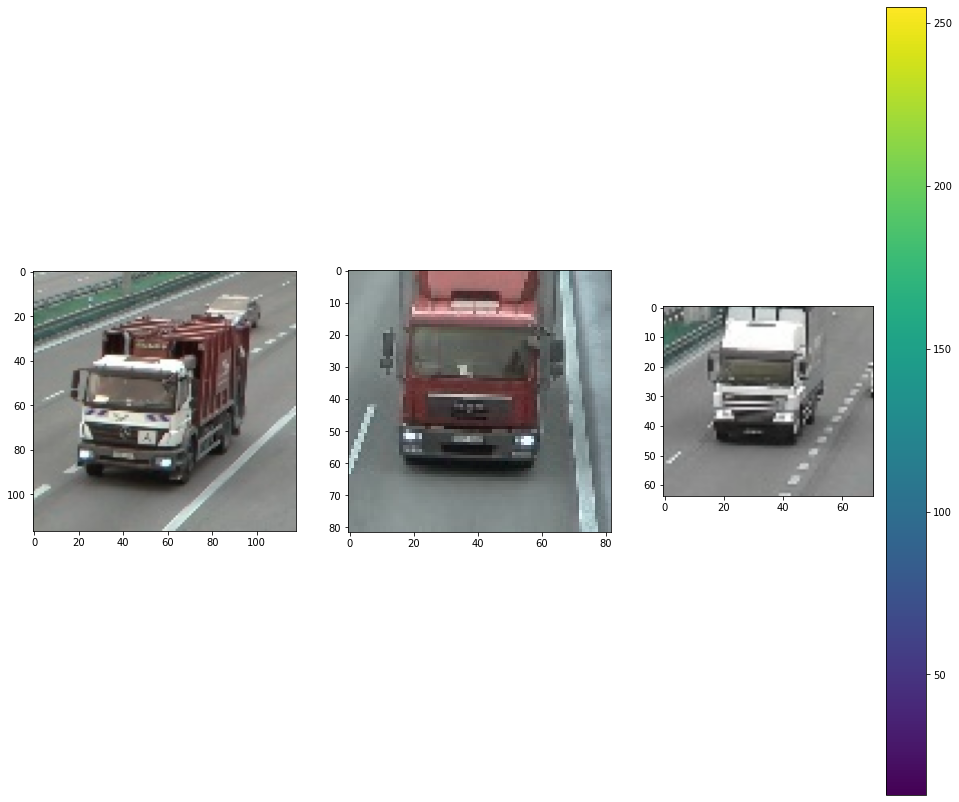

Samples images Van


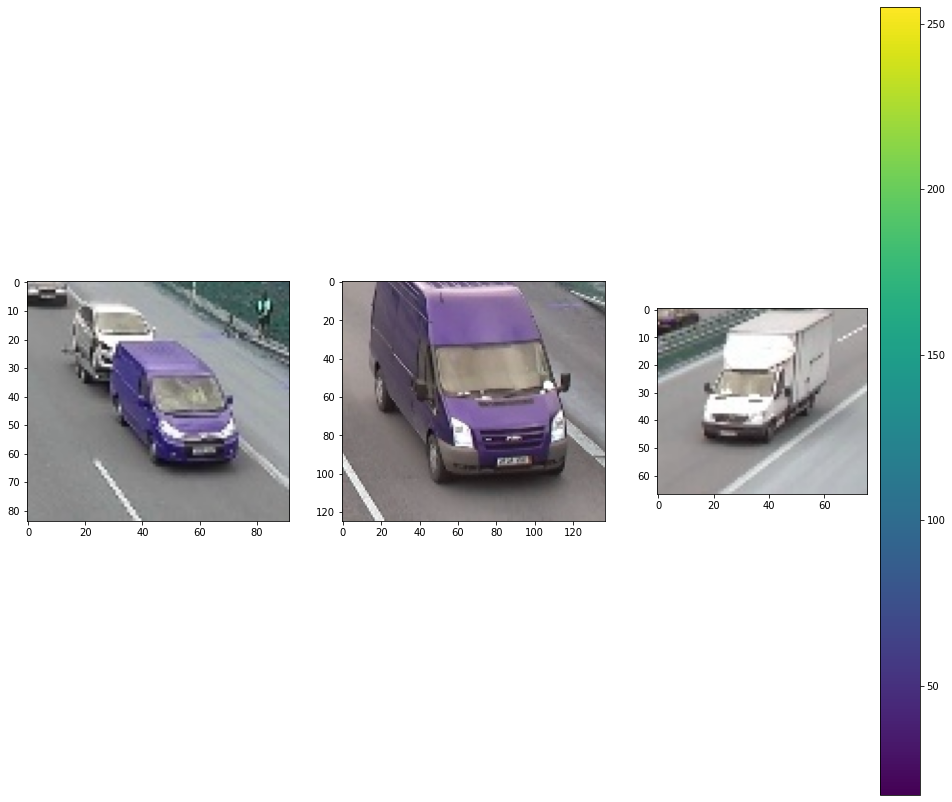

In [12]:
plotSample('Big Truck')
plotSample('City Car')
plotSample('Multi Purpose Vehicle')
plotSample('Sedan')
plotSample('Sport Utility Vehicle')
plotSample('Truck')
plotSample('Van')

## Building the Multi Layer Perceptron model 

In [13]:
MLP_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=resizeDim),
    tf.keras.layers.Dense(200, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(200, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(200, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(7, activation = "softmax")
])

MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 200)               2457800   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 100)               2

In [14]:
MLP_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

#### Defining a function to determine the learning_rate decay based on epoch schedule.

In [15]:
def scheduler(epoch):
    if epoch < 25:
        return 0.00001
    else:
        return 0.00001 * math.exp(0.1 * (25 - epoch))

In [16]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [17]:
MLP = MLP_model.fit_generator(train_generator, epochs=50, steps_per_epoch = 221,validation_data=val_generator,callbacks = [callback], verbose = 1)

C:\Users\Raman\AppData\Local\Temp/ipykernel_17204/3278932204.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  MLP = MLP_model.fit_generator(train_generator, epochs=50, steps_per_epoch = 221,validation_data=val_generator,callbacks = [callback], verbose = 1)


Epoch 1/50
221/221 [==============================] - 116s 524ms/step - loss: 5.7129 - accuracy: 0.2878 - val_loss: 5.5063 - val_accuracy: 0.3590 - lr: 1.0000e-05
Epoch 2/50
221/221 [==============================] - 13s 57ms/step - loss: 5.4100 - accuracy: 0.3748 - val_loss: 5.2415 - val_accuracy: 0.4160 - lr: 1.0000e-05
Epoch 3/50
221/221 [==============================] - 13s 58ms/step - loss: 5.1817 - accuracy: 0.4324 - val_loss: 5.0348 - val_accuracy: 0.4622 - lr: 1.0000e-05
Epoch 4/50
221/221 [==============================] - 13s 59ms/step - loss: 4.9946 - accuracy: 0.4763 - val_loss: 4.8762 - val_accuracy: 0.5071 - lr: 1.0000e-05
Epoch 5/50
221/221 [==============================] - 12s 53ms/step - loss: 4.8446 - accuracy: 0.5044 - val_loss: 4.7449 - val_accuracy: 0.5231 - lr: 1.0000e-05
Epoch 6/50
221/221 [==============================] - 12s 53ms/step - loss: 4.7110 - accuracy: 0.5301 - val_loss: 4.6208 - val_accuracy: 0.5558 - lr: 1.0000e-05
Epoch 7/50
221/221 [============

## After training the MLP model we get a Training Accuracy of 87.71% and a Validation Accuracy of 74.29%

In [18]:
MLP_history = pd.DataFrame(MLP.history)

#### Plotting the accuracy and validation accuracy

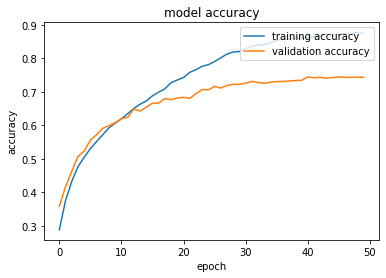

In [19]:
MLP_history.loc[0:, ['accuracy','val_accuracy']].plot()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper right')
plt.show()

### Plotting the loss and validation loss 

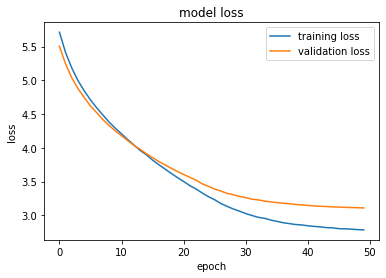

In [20]:
MLP_history.loc[0:, ['loss', 'val_loss']].plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

### Saving the MLP model

In [21]:
MLP_model.save(r'D:/ML/Vehicle Image Classification/Model/MLP model.model')

INFO:tensorflow:Assets written to: D:/ML/Vehicle Image Classification/Model/MLP model.model\assets


###  Inference -  Since the validation accuracy is a bit more less with respect the training accuracy than normal cases, we can say that the model might have been a little overfitted on the training set. 


### Multi layer perceptron network is not considered to be very efficient over image data. Convolutional neural networks are considered to be more efficient since they also take into consideration, the pixels with their spatial structure and hence perform better than MLP networks. Therefore now we will try this project with CNN approach.

## Building the CNN model

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [23]:
CNN_model = Sequential([
    Conv2D(32, (5, 5), input_shape=(64, 64, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    tf.keras.layers.Dropout(rate=0.3),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
CNN_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
CNN = CNN_model.fit(
    train_generator,
    epochs=50,
    batch_size=64,
    verbose=2,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/50
221/221 - 42s - loss: 1.4049 - accuracy: 0.4320 - val_loss: 1.1430 - val_accuracy: 0.5481 - 42s/epoch - 190ms/step
Epoch 2/50
221/221 - 42s - loss: 0.9682 - accuracy: 0.6136 - val_loss: 0.8671 - val_accuracy: 0.6667 - 42s/epoch - 191ms/step
Epoch 3/50
221/221 - 42s - loss: 0.7701 - accuracy: 0.6964 - val_loss: 0.6947 - val_accuracy: 0.7365 - 42s/epoch - 190ms/step
Epoch 4/50
221/221 - 42s - loss: 0.6292 - accuracy: 0.7509 - val_loss: 0.6425 - val_accuracy: 0.7545 - 42s/epoch - 191ms/step
Epoch 5/50
221/221 - 42s - loss: 0.5191 - accuracy: 0.7969 - val_loss: 0.5727 - val_accuracy: 0.7840 - 42s/epoch - 190ms/step
Epoch 6/50
221/221 - 43s - loss: 0.4324 - accuracy: 0.8312 - val_loss: 0.5068 - val_accuracy: 0.8160 - 43s/epoch - 194ms/step
Epoch 7/50
221/221 - 43s - loss: 0.3565 - accuracy: 0.8637 - val_loss: 0.5038 - val_accuracy: 0.8276 - 43s/epoch - 193ms/step
Epoch 8/50
221/221 - 42s - loss: 0.3015 - accuracy: 0.8878 - val_loss: 0.4445 - val_accuracy: 0.8551 - 42s/epoch - 190

## After training the CNN model we get a Training Accuracy of 95.00% and a Validation Accuracy of 87.12%, which shows that the CNN model has gained a much higher precision both in training and validation cases than the MLP model.

In [27]:
CNN_history = pd.DataFrame(CNN.history)

#### Plotting the accuracy and validation accuracy

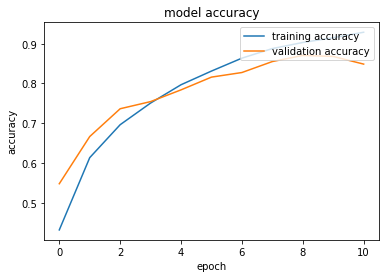

In [28]:
CNN_history.loc[0:, ['accuracy','val_accuracy']].plot()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper right')
plt.show()

#### Plotting the loss and validation loss

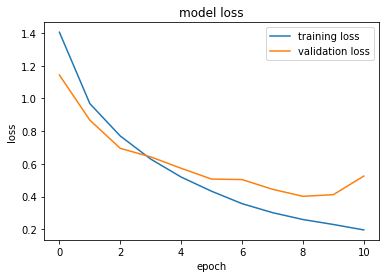

In [29]:
CNN_history.loc[0:, ['loss', 'val_loss']].plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

### Saving the CNN model

In [30]:
CNN_model.save(r'D:/ML/Vehicle Image Classification/Model/CNN model.model')

INFO:tensorflow:Assets written to: D:/ML/Vehicle Image Classification/Model/CNN model.model\assets
